<a href="https://colab.research.google.com/github/fernandofsilva/LSTM_Option_Pricing/blob/main/notebooks/05_analise_resultados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
#@title Carregando as bibliotecas base
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

from sklearn.metrics import mean_squared_error, mean_absolute_error

seaborn.set_style('whitegrid')

# Carregando dados

In [2]:
#@title Carregando os dados
data = pd.read_csv(f'/content/drive/My Drive/Mestrado/data/dados_treino_teste.csv.gz', compression='gzip', index_col=0)
data = data[data['base'] == 'teste']
data.head()

,codigo,mercado,preco_opcao,preco_exercicio,data_vencimento,T,preco_ativo,volatilidade,taxa_juros,black_scholes,delta_black_scholes,base
2015-01-05,PETRM2,OPÇÕES DE VENDA,0.02,4.91,2015-01-19,0.039683,8.61,0.771953,0.1157,0.00,0,teste
2015-01-05,PETRM27,OPÇÕES DE VENDA,2.54,11.16,2015-01-19,0.039683,8.61,0.771953,0.1157,2.53,94,teste
2015-01-05,PETRM4,OPÇÕES DE VENDA,3.95,12.66,2015-01-19,0.039683,8.61,0.771953,0.1157,4.00,99,teste
2015-01-05,PETRM45,OPÇÕES DE VENDA,0.28,8.21,2015-01-19,0.039683,8.61,0.771953,0.1157,0.32,34,teste
2015-01-05,PETRM3,OPÇÕES DE VENDA,4.98,13.66,2015-01-19,0.039683,8.61,0.771953,0.1157,4.99,100,teste


In [3]:
#@title Load Predições DNN
dnn = np.load('/content/drive/My Drive/Mestrado/data/predicao_dnn.npz')
dnn['dnn']

array([[0.01660939],
       [2.5536246 ],
       [4.009334  ],
       ...,
       [0.01540385],
       [1.0448093 ],
       [2.2691905 ]], dtype=float32)

In [4]:
#@title Load Predições LSTM
lstm = np.load('/content/drive/My Drive/Mestrado/data/predicao_lstm.npz')
lstm['lstm']

array([[0.01043269],
       [2.528364  ],
       [4.013221  ],
       ...,
       [0.03485066],
       [1.1643875 ],
       [2.3879173 ]], dtype=float32)

In [5]:
#@title Juntar bases
data['dnn'] = dnn['dnn']
data['lstm'] = lstm['lstm']
data[['preco_opcao','black_scholes', 'dnn', 'lstm']].head()

,preco_opcao,black_scholes,dnn,lstm
2015-01-05,0.02,0.00,0.016609,0.010433
2015-01-05,2.54,2.53,2.553625,2.528364
2015-01-05,3.95,4.00,4.009334,4.013221
2015-01-05,0.28,0.32,0.316790,0.272456
2015-01-05,4.98,4.99,4.984253,5.020415


# Métricas

Abaixo são apresentadas as métricas de erro médio quadrao e erro médio absoluto, considerando dados gerais (a base completa), opções **ITM** (delta menor que 40), opções **ATM** (dela de 40 a 60) e opções **OTM** (delta maior que 60).

In [102]:
#@title
def metric(data, mercado=None):

    # Filter
    if mercado:
        data = data[data['mercado'] == mercado]

    # Calculate metrics
    mse_bs = mean_squared_error(data['preco_opcao'], data['black_scholes'])
    mse_dnn = mean_squared_error(data['preco_opcao'], data['dnn'])
    mse_lstm = mean_squared_error(data['preco_opcao'], data['lstm'])
    mae_bs = mean_absolute_error(data['preco_opcao'], data['black_scholes'])
    mae_dnn = mean_absolute_error(data['preco_opcao'], data['dnn'])
    mae_lstm = mean_absolute_error(data['preco_opcao'], data['lstm'])

    # Create data
    bs = [mse_bs, mae_bs]
    dnn = [mse_dnn, mae_dnn]
    lstm = [mse_lstm, mae_lstm]

    # Compose dataframe
    data = pd.DataFrame({'black_scholes': bs, 'dnn': dnn, 'lstm': lstm}, index=['MSE', 'MAE'])

    # Get minimum values
    min_values = data.apply(min, axis=1)

    # Instantiate a list
    minimum = []

    # Loop over the dataframe
    for (index, row), values in zip(data.iterrows(), min_values):
        minimum.append(row[row == values].index[0])

    # create column
    data['lowest_model'] = minimum

    return data

## Geral

In [104]:
# Geral
metric(data)

,black_scholes,dnn,lstm,lowest_model
MSE,0.103736,0.052400,0.050036,lstm
MAE,0.153545,0.110214,0.103609,lstm


In [105]:
metric(data, 'OPÇÕES DE COMPRA')

,black_scholes,dnn,lstm,lowest_model
MSE,0.121324,0.060197,0.056372,lstm
MAE,0.164591,0.119130,0.112233,lstm


In [106]:
metric(data, 'OPÇÕES DE VENDA')

,black_scholes,dnn,lstm,lowest_model
MSE,0.076214,0.040200,0.040122,lstm
MAE,0.136259,0.096262,0.090114,lstm


## Opções ITM

In [107]:
ITM = data[data['delta_black_scholes'] > 60]
metric(ITM)

,black_scholes,dnn,lstm,lowest_model
MSE,0.132993,0.083454,0.085210,dnn
MAE,0.175740,0.147891,0.146155,lstm


In [108]:
metric(ITM, 'OPÇÕES DE COMPRA')

,black_scholes,dnn,lstm,lowest_model
MSE,0.144108,0.076299,0.073818,lstm
MAE,0.179621,0.143081,0.140313,lstm


In [109]:
metric(ITM, 'OPÇÕES DE VENDA')

,black_scholes,dnn,lstm,lowest_model
MSE,0.107738,0.099711,0.111093,dnn
MAE,0.166922,0.158818,0.159428,dnn


## Opções ATM

In [110]:
ATM = data[(data['delta_black_scholes'] >= 40) & 
           (data['delta_black_scholes'] <= 60)]
metric(ATM)

,black_scholes,dnn,lstm,lowest_model
MSE,0.206989,0.073300,0.062933,lstm
MAE,0.268016,0.160528,0.141960,lstm


In [111]:
metric(ATM, 'OPÇÕES DE COMPRA')

,black_scholes,dnn,lstm,lowest_model
MSE,0.248599,0.087122,0.076084,lstm
MAE,0.294781,0.170136,0.151763,lstm


In [112]:
metric(ATM, 'OPÇÕES DE VENDA')

,black_scholes,dnn,lstm,lowest_model
MSE,0.136549,0.049900,0.040671,lstm
MAE,0.222705,0.144262,0.125365,lstm


##Opções OTM

In [113]:
OTM = data[data['delta_black_scholes'] < 40]
metric(OTM)

,black_scholes,dnn,lstm,lowest_model
MSE,0.055628,0.027843,0.025441,lstm
MAE,0.106247,0.072960,0.067060,lstm


In [114]:
metric(OTM, 'OPÇÕES DE COMPRA')

,black_scholes,dnn,lstm,lowest_model
MSE,0.061419,0.039198,0.036824,lstm
MAE,0.109420,0.084186,0.078128,lstm


In [115]:
metric(OTM, 'OPÇÕES DE VENDA')

,black_scholes,dnn,lstm,lowest_model
MSE,0.048408,0.013687,0.011250,lstm
MAE,0.102292,0.058967,0.053262,lstm


# Gráficos

In [185]:
#@title
def plot(data, codigo, data_vencimento, days=None):
    #Filter
    data = data[(data['codigo'] == codigo) & (data['data_vencimento'] == data_vencimento)]

    if days:
        data = data[-days:]

    # Error
    bs = mean_squared_error(data['preco_opcao'], data['black_scholes'])
    dnn = mean_squared_error(data['preco_opcao'], data['dnn'])
    lstm = mean_squared_error(data['preco_opcao'], data['lstm'])

    # Plot
    fig, axs = plt.subplots(figsize=(20, 4))
    axs.plot(data.index, data['preco_opcao'], 'tab:gray', label=codigo)
    axs.plot(data.index, data['black_scholes'], 'tab:blue', label='bs')
    axs.plot(data.index, data['dnn'], 'tab:red', label='dnn')
    axs.plot(data.index, data['lstm'], 'tab:green', label='lstm')
    axs.set_title(f'{codigo} - Black-Scholes:{bs:.4f}, DNN:{dnn:.4f}, LSTM:{lstm:.4f}')
    axs.set(ylabel='Valor R$')
    axs.set(xlabel='data')
    axs.tick_params(axis='x', labelrotation=45)
    axs.legend()

    plt.show()

## Opções ITM

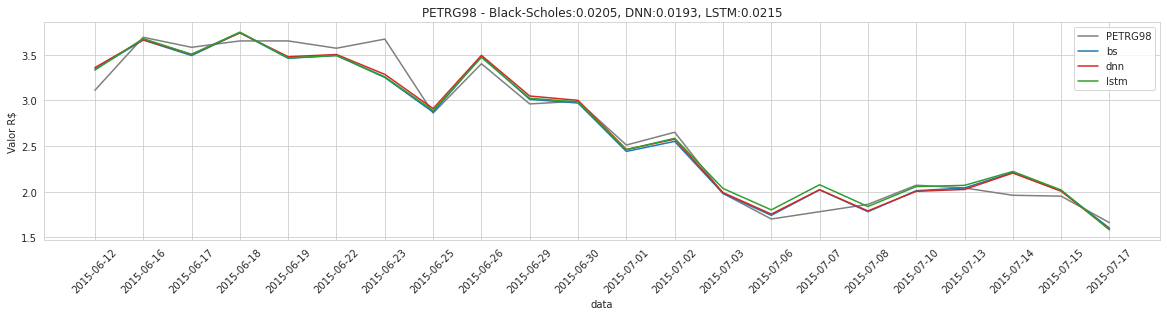

In [186]:
# OPÇÕES DE COMPRA (LSTM)
plot(data, 'PETRG98', '2015-07-20', 22)

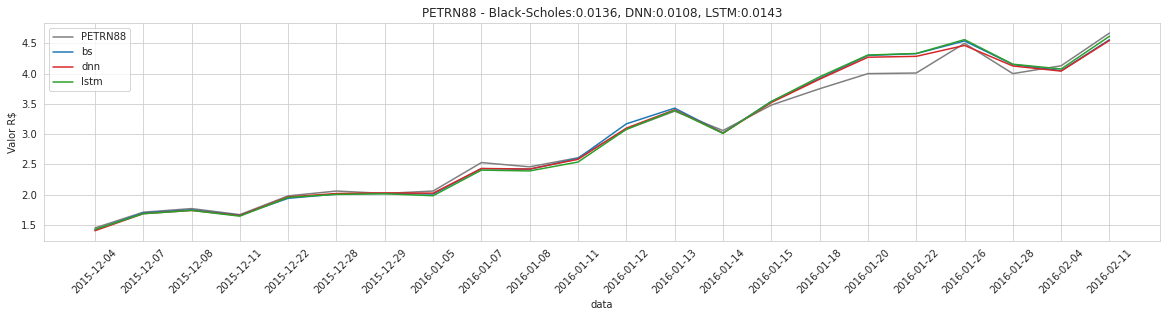

In [187]:
# OPÇÕES DE VENDA (DNN)
plot(data, 'PETRN88', '2016-02-15', 22)

## Opções ATM

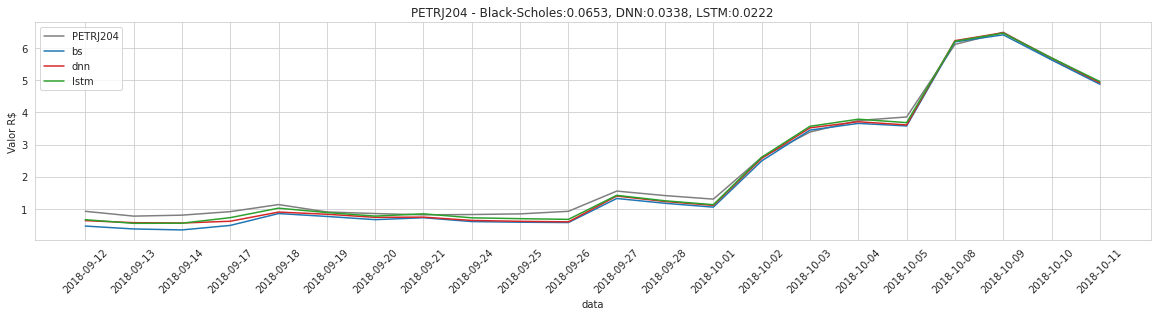

In [188]:
# OPÇÕES DE COMPRA (LSTM)
plot(data, 'PETRJ204', '2018-10-15', 22)

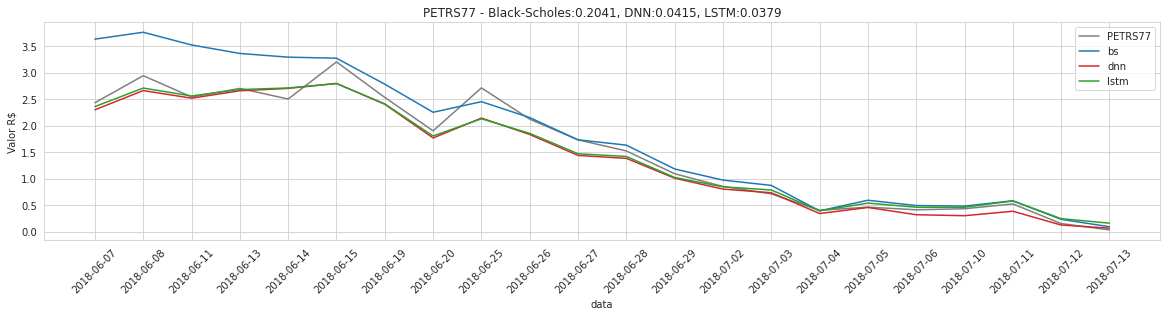

In [189]:
# OPÇÕES DE VENDA (LSTM)
plot(data, 'PETRS77', '2018-07-16', 22)

## Opções OTM

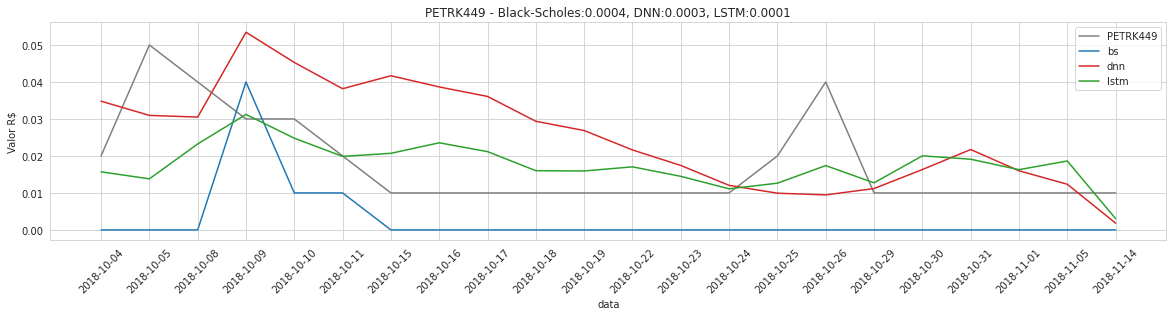

In [190]:
# OPÇÕES DE COMPRA (LSTM)
plot(data, 'PETRK449', '2018-11-19', 22)

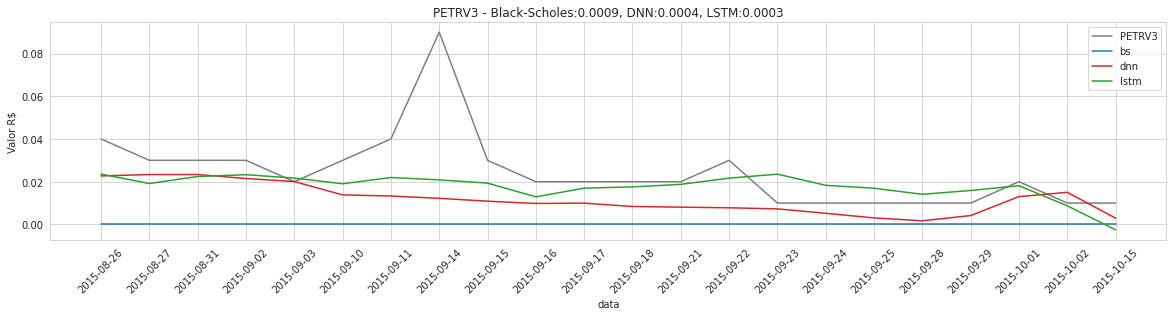

In [195]:
index = 1
codigo = x.iloc[index, 0]
data_vencimento = x.iloc[index, 1]

# OPÇÕES DE VENDA (LSTM)
plot(data, codigo, data_vencimento, 22)